# Model Evaluation

In [1]:
# Load libraries
import sys
import os
import warnings
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, ConfusionMatrixDisplay, f1_score
from sklearn.preprocessing import binarize
from sklearn.tree import export_text

In [2]:
# Set working directory - ONLY RUN ONCE
os.chdir('../')

In [3]:
import resources.data_preprocessing as dp
import resources.split_normalization as sn
import resources.dummies_colinearity as dc
import models.random_forest as rf
import models.endline_analysis as ea
import models.nn as nn
import plots.plots as plts

In [4]:
# Hyde warnings
warnings.filterwarnings('ignore')

### Data loading and preprocessing

In [5]:
# File paths
file_dir = os.path.abspath('')
face_cov_filepath = os.path.join(file_dir,"data","face_covering.csv")
demographics_filepath = os.path.join(file_dir,"data","demographics_2021.csv")

In [6]:
# Load data
demographics = dp.load_demographics(demographics_filepath)
face_covering = dp.load_referendum(face_cov_filepath)

In [7]:
# Merge data
merged_data_raw = dp.merge_demographics_referendum(demographics, face_covering)
merged_data_raw = merged_data_raw[merged_data_raw['yes'].notna()]

In [8]:
# Remove irrelevant attributes
rm_attr = ["id", "canton_id", "municipality_ref", "age_percentage_less_20", "death_rate",
        "social_aid_perc", "employment_total", "establishments_total", "establishments_primary",
        "establishments_secondary", "establishments_tertiary", "cast_ballots", "participation_rate", 
        "registered_voters", "blank_votes", "invalid_votes", "valid_ballots", "yes_count", "no_count",
          "PLR", "PDC", "PS", "UDC", "PEV_PCS", "PVL", "PBD", "PST_Sol", "PES", "small_right_parties"]
merged_data = merged_data_raw.drop(rm_attr, axis = 1)

In [9]:
# Create dummy columns for categorical attributes
dummy_cols = ["canton"]
merged_data = dc.add_dummies(merged_data, dummy_cols)

In [10]:
# Separate X and y
X_attr = merged_data.columns.to_list()
X_attr.remove('yes')
X = merged_data.drop(["yes"], axis = 1)
y_attr = "yes"
y = merged_data["yes"]

In [11]:
# Split data into train, development and test
X_train_all, X_test_all, X_dev_all, y_train, y_test, y_dev = sn.split(X, y)
print("Shapes:\nX_train :", X_train_all.shape, "\nX_dev: ", X_dev_all.shape, "\nX_test: ", X_test_all.shape)

Shapes:
X_train : (1733, 51) 
X_dev:  (217, 51) 
X_test:  (217, 51)


In [12]:
# Handle NAs
for dataframe in [X_train_all, X_test_all, X_dev_all]:
    dataframe = dp.handle_na(dataframe, fill = "KNN", nn=5)

In [13]:
# Remove yes_perc (required later for evaluation)
X_train = X_train_all.drop(["yes_perc", "municipality_dem"], axis = 1)
X_test = X_test_all.drop(["yes_perc", "municipality_dem"], axis = 1)
X_dev = X_dev_all.drop(["yes_perc", "municipality_dem"], axis = 1)

X_attr_2 = [c for c in X_attr if c not in ["yes_perc", "municipality_dem"]]

In [14]:
# Save column names
X_cols = X_train.columns

In [15]:
# Scale attributes
X_train, X_test, X_dev = sn.min_max_scaling(X_train, X_test, X_dev)

In [16]:
# Add column names
X_train.columns = X_cols
X_test.columns = X_cols
X_dev.columns = X_cols

In [17]:
list(X_train)

['population',
 'population_variation',
 'population_density',
 'foreigner_percentage',
 'age_percentage_between_20_64',
 'age_percentage_more_64',
 'marriage_rate',
 'divorce_rate',
 'birth_rate',
 'private_households',
 'avg_household_size',
 'total_surface',
 'housing_and_infrastructure_surface',
 'housing_and_infrastructure_surface_variation',
 'agriculture_surface_perc',
 'agriculture_variation_surface_perc',
 'forest_surface_perc',
 'unproductive_surface_perc',
 'employment_primary',
 'employment_secondary',
 'employment_tertiary',
 'empty_housing_units',
 'new_housing_units_per_capita',
 'canton_Aargau',
 'canton_Appenzell_Ausserrhoden',
 'canton_Appenzell_Innerrhoden',
 'canton_Basel_Landschaft',
 'canton_Basel_Stadt',
 'canton_Bern',
 'canton_Fribourg',
 'canton_Geneve',
 'canton_Glarus',
 'canton_Graubunden',
 'canton_Jura',
 'canton_Luzern',
 'canton_Neuchatel',
 'canton_Nidwalden',
 'canton_Obwalden',
 'canton_Schaffhausen',
 'canton_Schwyz',
 'canton_Solothurn',
 'canton_S

### Modelling 

In [18]:
labels = ["no", "yes"]

#### Logistic Regression

In [19]:
# Find best params for logistic regression
lg_dict, accuracies_lg = ea.logistic_reg_hp(X_train, X_dev, y_train, y_dev)

In [20]:
accuracies_display = accuracies_lg.params.apply(pd.Series)
accuracies_display['mean_acc'] = accuracies_lg['mean_acc']
accuracies_display

,C,penalty,solver,mean_acc
0,100.00,l2,newton-cg,0.839487
1,100.00,l2,lbfgs,0.839487
2,100.00,l2,liblinear,0.839658
3,10.00,l2,newton-cg,0.838632
4,10.00,l2,lbfgs,0.838632
5,10.00,l2,liblinear,0.838462
6,1.00,l2,newton-cg,0.833162
7,1.00,l2,lbfgs,0.833162
8,1.00,l2,liblinear,0.833162
9,0.10,l2,newton-cg,0.829402


In [21]:
# Make prediction with best params
y_pred_lg = ea.logistic_reg_max_hp(X_train, X_test, y_train, y_test, max_params=lg_dict["max_params"])

In [22]:
# Evaluation metrics
print("Classification report: \n", classification_report(y_test, y_pred_lg))

Classification report: 
               precision    recall  f1-score   support

         0.0       0.56      0.19      0.29        26
         1.0       0.90      0.98      0.94       191

    accuracy                           0.88       217
   macro avg       0.73      0.59      0.61       217
weighted avg       0.86      0.88      0.86       217



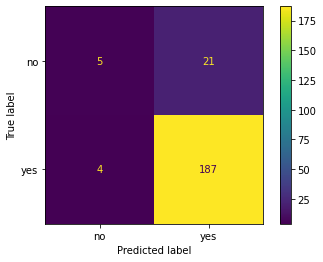

In [23]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lg)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [24]:
# Plot % Yes & Error
plts.plot_yes_perc_error(X_test_all, y_test, y_pred_lg) 

#### KNN

In [25]:
# Find best k for KNN model
best_k_dict, accuracies_knn = ea.knn_analysis_hp(X_train, X_dev, y_train, y_dev)

In [26]:
accuracies_knn

,k,accu_rate
0,1.0,0.792627
1,3.0,0.815668
2,5.0,0.801843
3,7.0,0.815668
4,9.0,0.824885
5,11.0,0.829493
6,13.0,0.847926
7,15.0,0.83871
8,17.0,0.83871
9,19.0,0.83871


<module 'matplotlib.pylab' from 'C:\\Users\\Jonas\\AppData\\Roaming\\Python\\Python310\\site-packages\\matplotlib\\pylab.py'>

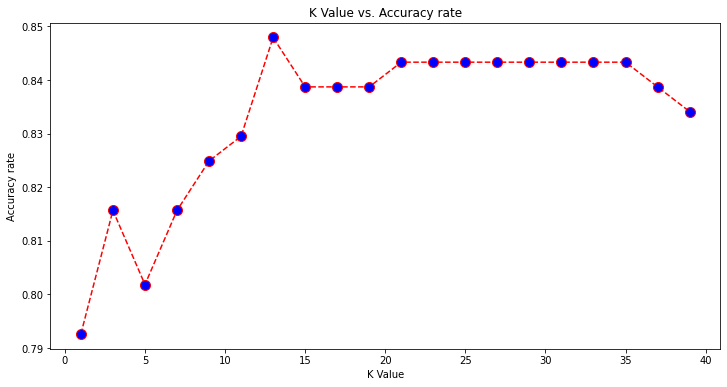

In [27]:
# Plot k vs accuracy 
ea.knn_k_plot(accuracies_knn)

In [28]:
# Make prediction with best k
y_pred_knn = ea.knn_analysis_max_k(X_train, X_test, y_train, y_test, best_k_dict["max_k"])

In [29]:
# Evaluation metrics
print("Classification report: \n", classification_report(y_test, y_pred_knn))

Classification report: 
               precision    recall  f1-score   support

         0.0       0.50      0.12      0.19        26
         1.0       0.89      0.98      0.94       191

    accuracy                           0.88       217
   macro avg       0.70      0.55      0.56       217
weighted avg       0.84      0.88      0.85       217



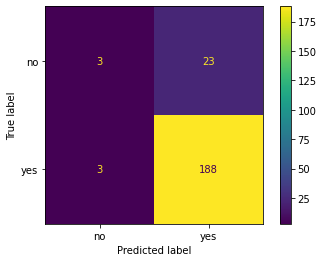

In [30]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_knn)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [31]:
# Plot % Yes & Error
plts.plot_yes_perc_error(X_test_all, y_test, y_pred_knn) 

#### Decision Tree

In [32]:
# Find best params for decision tree
dt_best_params_dict, accuracies_dt = ea.decision_tree_hp(X_train, X_dev, y_train, y_dev)
accuracies_dt

,criterion,depth,accu_rate
0,gini,1,0.834101
1,gini,2,0.843318
2,gini,3,0.852535
3,gini,4,0.852535
4,gini,5,0.857143
...,...,...,...
93,entropy,45,0.769585
94,entropy,46,0.769585
95,entropy,47,0.769585
96,entropy,48,0.769585


In [33]:
# Make prediction with best params
y_pred_dt, clf = ea.decision_tree_max_hp(X_train, X_test, y_train, y_test, 
                                    dt_best_params_dict["max_criterion"], 
                                    dt_best_params_dict["max_depth_tree"])

In [34]:
# Plot best decision tree - Move Pavan's code in decision_tree.py to function
print("Textual model: \n")
r = export_text(clf, feature_names=X_attr_2)
print(r)

Textual model: 

|--- population <= 0.02
|   |--- canton_Graubunden <= 0.50
|   |   |--- population_density <= 0.03
|   |   |   |--- private_households <= 0.12
|   |   |   |   |--- forest_surface_perc <= 0.31
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- forest_surface_perc >  0.31
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- private_households >  0.12
|   |   |   |   |--- housing_and_infrastructure_surface_variation <= 0.13
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- housing_and_infrastructure_surface_variation >  0.13
|   |   |   |   |   |--- class: 1.0
|   |   |--- population_density >  0.03
|   |   |   |--- employment_secondary <= 0.02
|   |   |   |   |--- population <= 0.01
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- population >  0.01
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- employment_secondary >  0.02
|   |   |   |   |--- empty_housing_units <= 0.00
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- empty_housing_un

In [35]:
# Evaluation metrics
print("Classification report: \n", classification_report(y_test, y_pred_dt))

Classification report: 
               precision    recall  f1-score   support

         0.0       0.43      0.23      0.30        26
         1.0       0.90      0.96      0.93       191

    accuracy                           0.87       217
   macro avg       0.67      0.59      0.61       217
weighted avg       0.84      0.87      0.85       217



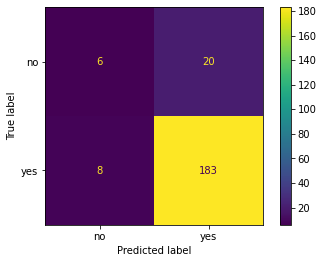

In [36]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [37]:
# Plot % Yes & Error
plts.plot_yes_perc_error(X_test_all, y_test, y_pred_dt) 

#### Random Forest

In [38]:
# Find best params for Random Forest model
best_params_rf, best_acc_rf, accuracies_rf = rf.random_forest(X_train=X_train, X_dev=X_dev, 
                                            y_train=y_train, y_dev=y_dev, random_state = True)

In [39]:
accuracies_rf

,criterion,n_estimators,max_depth,accuracy
0,gini,1,1,0.838710
1,gini,1,5,0.843318
2,gini,1,10,0.797235
3,gini,1,20,0.774194
4,gini,1,40,0.774194
...,...,...,...,...
283,entropy,500,200,0.852535
284,entropy,500,250,0.852535
285,entropy,500,300,0.852535
286,entropy,500,400,0.852535


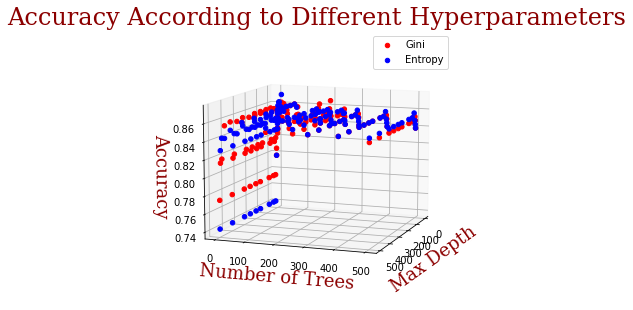

In [40]:
# Plot random forests' accuracies based on parameters
rf.plot_random_forest(accuracies_rf)

In [41]:
# Make prediction with best model
y_test_pred_rf = rf.predict_random_forest(best_params_rf, X_train, y_train, X_test, random_state = True)

In [42]:
# Evaluation metrics 
print("Test Data - Classification Report: \n", classification_report(y_test, y_test_pred_rf))

Test Data - Classification Report: 
               precision    recall  f1-score   support

         0.0       0.57      0.31      0.40        26
         1.0       0.91      0.97      0.94       191

    accuracy                           0.89       217
   macro avg       0.74      0.64      0.67       217
weighted avg       0.87      0.89      0.87       217



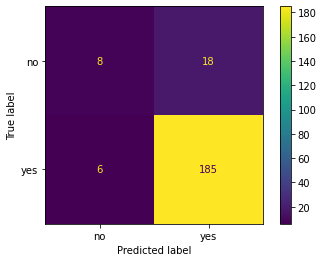

In [43]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_rf)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

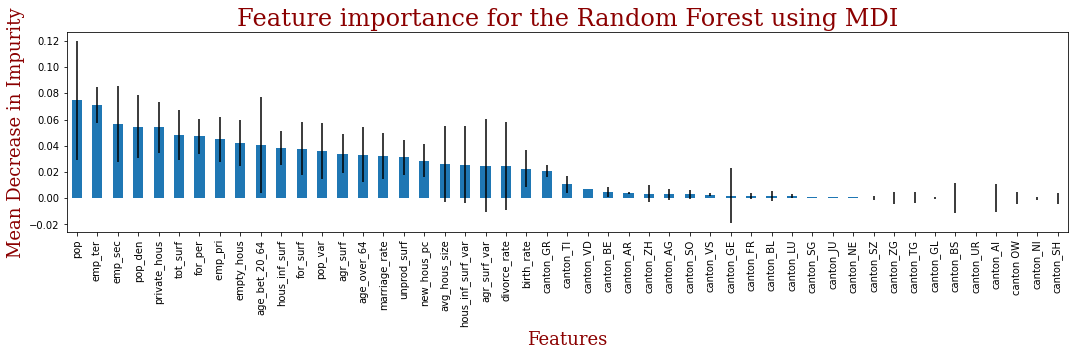

In [44]:
# Feature Importance
rf.feature_importance_random_forest(X_train, y_train, best_params_rf)

In [45]:
# Plot % Yes & Error
plts.plot_yes_perc_error(X_test_all, y_test, y_test_pred_rf) 

#### Neural Networks 

In [46]:
# Find best params for neural net
best_parameters_nn, best_accuracy_nn, accuracies_nn = nn.fit_nn(X_train, X_dev, y_train, y_dev)

In [47]:
accuracies_nn

,activation_function,n_layers,n_nodes,accuracy
0,logistic,2,2,0.83871
1,logistic,2,3,0.83871
2,logistic,2,4,0.83871
3,logistic,2,5,0.83871
4,logistic,2,6,0.83871
...,...,...,...,...
238,relu,10,6,0.83871
239,relu,10,7,0.83871
240,relu,10,8,0.83871
241,relu,10,9,0.83871


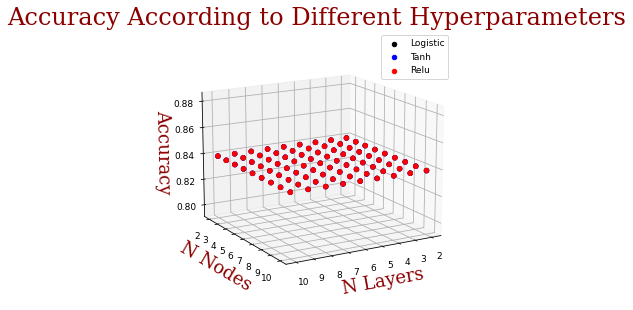

In [48]:
# Plot tested params & accuracies
nn.plot_nn(accuracies_nn)

In [49]:
# Make prediction with best model 
y_pred_nn = nn.predict_best_model_nn(best_parameters_nn, X_train, y_train, X_test)

In [50]:
# Evaluation metrics
print("Classification report: \n", classification_report(y_test, y_pred_nn))

Classification report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        26
         1.0       0.88      1.00      0.94       191

    accuracy                           0.88       217
   macro avg       0.44      0.50      0.47       217
weighted avg       0.77      0.88      0.82       217



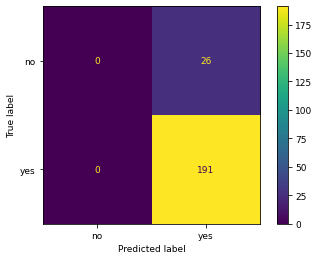

In [51]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_nn)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [52]:
# Plot % Yes & Error
plts.plot_yes_perc_error(X_test_all, y_test, y_pred_nn) 

### Conclusions

In [53]:
# Table comparing best models and accuracies?
models = ['Logistic Regression', 'KNN', 'Decision Trees', 'Random_Forest', 'Neural Networks']
outputs = [y_pred_lg, y_pred_knn, y_pred_dt, y_test_pred_rf, y_pred_nn]
table = []

for model, y_pred in zip(models, outputs):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy_all = (tn + tp) / len(y_pred)
    specificity = tn / (tn + fp)
    recall = tp / (tp + fn)
    table.append([model, accuracy_all, specificity, recall])
                  
 
all_results = pd.DataFrame(table, columns= ['Model','Accuracy','Specificity', 'recall'])
all_results
    

,Model,Accuracy,Specificity,recall
0,Logistic Regression,0.884793,0.192308,0.979058
1,KNN,0.880184,0.115385,0.984293
2,Decision Trees,0.870968,0.230769,0.958115
3,Random_Forest,0.889401,0.307692,0.968586
4,Neural Networks,0.880184,0.000000,1.000000
